In [0]:
from pyspark.sql.functions import col, when, to_timestamp
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from xgboost.spark import SparkXGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import json
from itertools import product
from sklearn.metrics import confusion_matrix

## Loads

In [0]:
base_dir = "dbfs:/student-groups/Group_4_1"
iter_name = "_2" # Inc

the_dataset = f"{base_dir}/otpw_5Y_checkpoint_9/"

gs_rf_best_dir = f"{base_dir}/rf_gs_cv{iter_name}"
gs_xg_best_dir = f"{base_dir}/xgb_gs_cv{iter_name}"
rf_best_models_dir = f"{base_dir}/rf_cv_models{iter_name}"
xg_best_models_dir = f"{base_dir}/xgb_cv_models{iter_name}"

delta_er = ""
data_name = "5_year_data" + delta_er

file_location = {
    data_name: the_dataset
}

LABEL_COL = "DEP_DELAY_GROUP_CLASSIFIED"
WEIGHT_COL = "class_weight"
DEVICE_USAGE = "gpu" #cpu or gpu

In [0]:
# Grid Search

rf_param_grid = {
    "numTrees": [100, 125],
    "maxDepth": [8],
    "maxBins": [32, 64],
    "featureSubsetStrategy": ["auto"],
}

xg_param_grid = { # Due to saving errors, the final refinement for XG PAram gird was lowered to this accordingly based on the best params report. The best params were already printed as this.
    "max_depth": [10],
    "n_estimators": [175],
    "learning_rate": [0.1],
    "subsample": [0.8],
    "colsample_bytree": [1.0],
    "reg_lambda": [2.0],
    "reg_alpha": [1.0],
}

## Feature Selection

In [0]:
# columns to drop before modeling
cols_to_remove = [
    "DEP_DELAY_NEW", "DEP_TIME", "DEP_DELAY", "DEP_DELAY_GROUP",
    "HourlySeaLevelPressure",
    "HourlyStationPressure",
    "HourlyDewPointTemperature",
    "origin_airport_lon",
    "DISTANCE_GROUP",
    "month",
    "DEP_TIME_BLK_ohe",
    "origin_region_ohe",
    "FL_DATE",
    "four_hours_prior_depart_UTC",
    "CRS_ARR_TIME", "CRS_DEP_TIME",
    "CRS_ELAPSED_TIME",
    "LATITUDE",
    
]

# feature candidates (from PCA + engineered features)
chosen_cols = [
    "CRS_DEP_TIME_SIN",
    "airline_reputation_score",
    "route_avg_delay_last_7days",
    "is_summer_peak",
    "HourlyRelativeHumidity",
    "CRS_DEP_TIME_COS",
    "OP_CARRIER_AIRLINE_ID",
    "dest_avg_delay_last_7days",
    "HourlyPrecipitation",
    "is_weekday",
    "hour_of_day",
    "origin_avg_delay_last_7days",
    "is_holiday_window",
    "HourlyDryBulbTemperature",
    "month",
    "HourlyDewPointTemperature",
    "avg_airline_pagerank",
    "HourlySeaLevelPressure",
    "Origin_FlightCount_PR_Scores",
    "day_of_week",
    "HourlyAltimeterSetting",
    "total_airline_pagerank",
    "is_us_holiday",
    "HourlyWindSpeed",
    "Weather_Index",
    "HourlyVisibility",
    "ORIGIN",
    "days_into_disruption",
    "is_weekend",
    "DISTANCE",
    "CRS_ELAPSED_TIME",
    "disruption_severity",
    "HourlyStationPressure",
    "Dest_FlightCount_PR_Scores",
    # "disaster_severity",
    # "is_GHC_window",
    # "HourlySkyConditions",
    # "DEST_AIRPORT_ID",
    # "days_since_disaster"
]

chosen_cols = list(set(chosen_cols))

PCA_columns = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindDirection",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyWindSpeed",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ARR_TIME",
    "DAY_OF_MONTH",
    "ORIGIN_AIRPORT_ID",
    "DEST_AIRPORT_ID",
    "OP_CARRIER_FL_NUM",
    "CRS_DEP_TIME",
    "ELEVATION",
    "origin_airport_lon",
    "origin_airport_lat",
    "dest_airport_lon",
    "dest_airport_lat",
    "LONGITUDE",
    "CRS_ELAPSED_TIME",
    "month",
    "day_of_week",
    "HourlyPrecipitation_was_missing",
    "wind_deg_imputed",
    "wind_dir_sin",
    "wind_dir_cos",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft",
]

PCA = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "CRS_ARR_TIME",
    "QUARTER",
    "day_of_week",
    "DAY_OF_MONTH",
    "CRS_DEP_TIME",
    "OP_CARRIER_FL_NUM",
    "dest_airport_lat",
    "ELEVATION",
    "LONGITUDE",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ELAPSED_TIME",
    "month",
    "dest_airport_lon",
    "origin_airport_lon",
    "origin_airport_lat",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft",
    "wind_deg_raw",
    "HourlyWindDirection_deg",
    "wind_dir_sin",
    "wind_dir_cos",
]
target_selected = list(set(chosen_cols + PCA_columns + PCA))

## Data Load

In [0]:
def load_df(file_dict):
    """
    Load first non-empty parquet path from file_dict.
    Returns {"name": key, "df": df}
    """
    for key, loc in file_dict.items():
        try:
            if len(dbutils.fs.ls(loc)) > 0:
                df = spark.read.parquet(loc)
                print(f"Loaded '{key}' from {loc}")
                df.printSchema()
                display(df)
                return {"name": key, "df": df}
            else:
                print(f"Skipping empty path: {loc}")
        except Exception as e:
            print(f"Skipping invalid path: {loc} ({e})")

    raise ValueError("No valid dataset found in file_location")

In [0]:
df_info = load_df(file_location)
dfs = [df_info]

Loaded '5_year_data' from dbfs:/student-groups/Group_4_1/otpw_5Y_checkpoint_9/
root
 |-- OP_CARRIER_AIRLINE_ID: double (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- ORIGIN_AIRPORT_ID: double (nullable = true)
 |-- DEST_AIRPORT_ID: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- DEP_DELAY_GROUP: double (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- QUARTER: double (nullable = true)
 |-- day_of_wee

OP_CARRIER_AIRLINE_ID YEAR month FL_DATE ORIGIN_AIRPORT_ID DEST_AIRPORT_ID DEP_TIME ORIGIN HourlyPrecipitation HourlySeaLevelPressure DEP_DELAY_GROUP HourlyWetBulbTemperature HourlyStationPressure HourlyWindSpeed HourlyRelativeHumidity HourlyDewPointTemperature HourlyDryBulbTemperature HourlyVisibility QUARTER day_of_week ELEVATION LONGITUDE LATITUDE ts_date DISTANCE CRS_ELAPSED_TIME HourlyAltimeterSetting is_us_holiday is_holiday_window is_summer_peak season is_weekday hour_of_day is_weekend is_superbowl_window is_GHC_window is_GHC_Host_Airport_Peak route_avg_delay_last_7days origin_avg_delay_last_7days dest_avg_delay_last_7days Weather_Index HourlySkyConditions CRS_DEP_TIME_SIN CRS_DEP_TIME_COS is_airport_disrupted is_federal_shutdown_day disruption_severity days_into_disruption Origin_FlightCount_PR_Scores Dest_FlightCount_PR_Scores total_airline_pagerank avg_airline_pagerank airline_reputation_score days_since_disaster disaster_severity is_CES_window is_CES_LasVegas_Peak 20304.0 2018 4 2018-04-01 10693.0 14492.0 2006.0 BNA 0.0 29.99 0.0 52.0 29.26 6.0 90.0 51.0 54.0 8.7 2.0 1 182.9 -86.68917 36.11889 2018-04-01T21:00:00 442.0 87.0 29.99 0 0 0 Spring 0 0 0 0 0 0 12.956354515050167 12.792410293080675 13.234721834191008 0.13015645062388498 Unknown -0.8767267557075079 0.48098876891938736 0 0 0 0 0.007749515347589402 0.005742955699121352 12125.673179509542 4.8815109418315386 88.96338657726943 0 0 0 0 20366.0 2017 10 2017-10-19 11057.0 15412.0 1811.0 CLT 0.0 30.22 7.0 56.0 29.4 5.0 38.0 44.0 71.0 10.0 4.0 4 221.9 -80.9552 35.2236 2017-10-19T16:52:00 177.0 60.0 30.23 0 0 0 Fall 1 20 0 0 0 0 16.69372197309417 12.265762010962503 15.140375182536413 0.6712988602915924 partly cloudy -0.8968727415326883 -0.44228869021900136 0 0 0 0 0.02252367749604308 0.0019158442377230239 8961.833934080278 5.4479233641825395 87.3336252189142 0 0 0 0 20304.0 2018 4 2018-04-03 11057.0 11433.0 1435.0 CLT 0.0 29.97 6.0 64.0 29.17 13.0 52.0 56.0 75.0 9.0 2.0 2 221.9 -80.9552 35.2236 2018-04-03T13:52:00 500.0 113.0 29.99 0 0 0 Spring 1 17 0 0 0 0 8.99712966429552 12.265762010962503 12.531071965091032 -0.9298899115704025 partly cloudy -0.27144044986507393 -0.9624552364536474 0 0 0 0 0.02252367749604308 0.021164494212159976 12125.673179509542 4.8815109418315386 88.96338657726943 0 0 0 0 20304.0 2018 4 2018-04-03 15380.0 11433.0 1844.0 TVC 0.07 29.7 3.0 32.0 29.01 14.0 92.0 31.0 33.0 0.75 2.0 2 188.4 -85.5825 44.74083 2018-04-03T17:53:00 207.0 69.0 29.68 0 0 0 Spring 1 21 0 0 0 0 13.440942154485626 15.993228972543173 12.531071965091032 0.8877128800529825 cloudy -0.9978589232386035 -0.06540312923014362 0 0 0 0 8.402977701610689E-4 0.021164494212159976 12125.673179509542 4.8815109418315386 88.96338657726943 0 0 0 0 20304.0 2018 4 2018-04-27 10693.0 13487.0 552.0 BNA 0.0 29.91 -1.0 55.0 29.26 6.0 65.0 49.0 61.0 10.0 2.0 5 182.9 -86.68917 36.11889 2018-04-27T07:53:00 695.0 141.0 29.91 0 0 0 Spring 1 10 0 0 0 0 12.513170731707318 12.792410293080675 11.693576645992753 -0.3693420090761207 clear sky 0.9996573249755573 0.02617694830787314 0 0 0 0 0.007749515347589402 0.02326971248310609 12125.673179509542 4.8815109418315386 88.96338657726943 0 0 0 0 20366.0 2017 10 2017-10-27 11057.0 12953.0 905.0 CLT 0.0 30.09 -1.0 53.0 29.28 7.0 67.0 48.0 59.0 10.0 4.0 5 221.9 -80.9552 35.2236 2017-10-27T09:52:00 544.0 122.0 30.1 0 0 0 Fall 1 13 0 0 0 0 17.245918100061118 12.265762010962503 19.01277193005824 0.4428062045923369 clear sky 0.6593458151000686 -0.7518398074789776 0 0 0 0 0.02252367749604308 0.015474866032023265 8961.833934080278 5.4479233641825395 87.3336252189142 0 0 0 0 20366.0 2017 10 2017-10-06 11057.0 12953.0 709.0 CLT 0.0 30.17 -1.0 64.0 29.36 0.0 84.0 62.0 67.0 10.0 4.0 5 221.9 -80.9552 35.2236 2017-10-06T07:52:00 544.0 119.0 30.19 0 0 0 Fall 1 11 0 0 1 0 17.245918100061118 12.265762010962503 19.01277193005824 -0.21400084649671303 partly cloudy 0.9469301294951057 -0.3214394653031616 0 0 0 0 0.02252367749604308 0.015474866032023265 8961.833934080278 5.44792336418253

## Deletion cleanup

In [0]:
def delete_dir_if_exists(path):
    """
    Deletes a DBFS file or directory if it exists.
    Safe: does nothing if the path does not exist.
    """
    try:
        files = dbutils.fs.ls(path)
        print(f"Deleting existing path: {path}")
        dbutils.fs.rm(path, recurse=True)
    except Exception:
        # Path does not exist — ignore
        pass

## Clean

In [0]:
def create_delay_groups(df):
    """
    DEP_DELAY_GROUP_CLASSIFIED:
    - not_delayed for groups -2, -1, 0
    - delayed otherwise
    """
    df_new = df.withColumn(
        LABEL_COL,
        when(col("DEP_DELAY_GROUP").isin(-2, -1, 0), "not_delayed").otherwise("delayed"),
    )
    return df_new


def prep_for_rf(df, label_col=LABEL_COL):
    """
    - Strip metadata
    - Cast strings (except label) to double
    - Fill numeric nulls with 0
    """
    banned = {label_col, "DEP_DELAY_GROUP"}

    df = df.select([F.col(c).alias(c, metadata={}) for c in df.columns])

    for c, t in df.dtypes:
        if t == "string" and c not in banned:
            df = df.withColumn(c, F.trim(F.col(c)))
            df = df.withColumn(c, F.when(F.col(c) == "", None).otherwise(F.col(c)))
            df = df.withColumn(c, F.col(c).cast("double"))

    numeric_cols = [c for c, t in df.dtypes if c not in banned and t in {"double", "float", "int", "bigint"}]
    if numeric_cols:
        df = df.fillna(0.0, subset=numeric_cols)
    else:
        raise ValueError("No numeric columns found after casting — check schema/label.")

    return df


## Splits

In [0]:
def year_split(df, min_year, max_year):
    """
    Rolling CV split:
    Train: year <= min_year
    Test : year == max_year
    """
    year_col = F.year(to_timestamp(col("FL_DATE")))
    train_df = df.filter(year_col <= min_year)
    test_df = df.filter(year_col == max_year)
    return train_df, test_df


def year_split_range(df, min_year, max_year):
    """
    Final train/test split:
    Train: year <= min_year
    Test : year >= max_year
    (Use min_year=2018, max_year=2019 → train 2015–2018, test 2019)
    """
    year_col = F.year(to_timestamp(col("FL_DATE")))
    train_df = df.filter(year_col <= min_year)
    test_df = df.filter(year_col >= max_year)
    return train_df, test_df


Configurations and pipelining

In [0]:
def drop_columns(df, columns_to_drop):
    for col_name in columns_to_drop:
        if col_name in df.columns:
            df = df.drop(col_name)
    return df

In [0]:
def add_es_validation_flag_by_year(
    df,
    val_year=2018,
    flag_col="isVal",
):
    """
    Mark rows from val_year as internal validation (for early stopping),
    all earlier years (2015–2017) remain pure training rows.
    """
    year_col = F.year(to_timestamp(col("FL_DATE")))
    return df.withColumn(flag_col, (year_col == F.lit(val_year)))

In [0]:
def get_train_test_filter_df(
    item, split_fn, drop_cols, lower, upper, elected_cols=None
):
    """
    Build a cleaned, labeled, filtered train/test split:
    - item: {"name": ..., "df": ...}
    - split_fn: year_split or year_split_range
    - drop_cols: columns to drop if present
    - lower/upper: years for split_fn
    - elected_cols: final feature selection list
    """
    df = item["df"]
    name = item["name"]

    df_dg = create_delay_groups(df)
    df_clean = prep_for_rf(df_dg)

    cols_to_drop = [
        c for c in drop_cols
        if c in df_clean.columns and c != LABEL_COL
    ]
    df_filtered = drop_columns(df_clean, cols_to_drop)

    if elected_cols is not None:
        cols_to_select = [c for c in elected_cols if c in df_filtered.columns]
        if LABEL_COL not in cols_to_select and LABEL_COL in df_filtered.columns:
            cols_to_select.append(LABEL_COL)
        df_filtered = df_filtered.select(*cols_to_select)
        feature_cols = [c for c in cols_to_select if c != LABEL_COL]
    else:
        feature_cols = [c for c in df_filtered.columns if c != LABEL_COL]

    train_df, test_df = split_fn(df_filtered, lower, upper)

    return {
        "name": name,
        "train_df": train_df.cache(),
        "test_df": test_df.cache(),
        "feature_cols": feature_cols,
    }


def model_pipeline(df_list, split_fn, lower, upper, drop_cols=None, elected_cols=None):
    """
    Apply get_train_test_filter_df to a list of {"name","df"} items.
    """
    if drop_cols is None:
        drop_cols = []
    df_split = []
    for item in df_list:
        df_items = get_train_test_filter_df(item, split_fn, drop_cols, lower, upper, elected_cols)
        df_split.append(df_items)
    return df_split


In [0]:
df_split_final = model_pipeline(
    dfs,
    year_split_range,
    2018,
    2019,
    cols_to_remove,
    target_selected,
)
final_train_df = df_split_final[0]["train_df"]
final_test_df = df_split_final[0]["test_df"]
final_features = df_split_final[0]["feature_cols"]
split_name = df_split_final[0]["name"]

In [0]:
# print("Final split:")
# print(f"  Train years <= 2018, count = {final_train_df.count()}")
# print(f"  Test years >= 2019, count = {final_test_df.count()}")

In [0]:
final_train_df.printSchema()

root
 |-- day_of_week: integer (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = false)
 |-- is_us_holiday: integer (nullable = true)
 |-- is_summer_peak: integer (nullable = true)
 |-- dest_avg_delay_last_7days: double (nullable = false)
 |-- hour_of_day: integer (nullable = true)
 |-- avg_airline_pagerank: double (nullable = false)
 |-- route_avg_delay_last_7days: double (nullable = false)
 |-- origin_avg_delay_last_7days: double (nullable = false)
 |-- DISTANCE: double (nullable = false)
 |-- DEST_AIRPORT_ID: double (nullable = false)
 |-- LONGITUDE: double (nullable = false)
 |-- is_weekday: integer (nullable = true)
 |-- QUARTER: double (nullable = false)
 |-- ORIGIN_AIRPORT_ID: double (nullable = false)
 |-- ELEVATION: double (nullable = false)
 |-- CRS_DEP_TIME_COS: double (nullable = false)
 |-- OP_CARRIER_AIRLINE_ID: double (nullable = false)
 |-- Origin_FlightCount_PR_Scores: double (nullable = false)
 |-- Weather_Index: double (nullable = false)
 |-- Hourly

## Adjustment functions

In [0]:
## Class Weights

def add_class_weights(label_col=LABEL_COL, weight_col=WEIGHT_COL):
    """
    Returns an adjust_fn(train_df, test_df) that adds a class_weight column to train_df
    based on label distribution, test_df unchanged.
    """
    def _adjust(train_df, test_df):
        counts = train_df.groupBy(label_col).count().withColumnRenamed("count", "cnt")
        total = counts.agg(F.sum("cnt")).first()[0]
        k = counts.count()

        weights_df = counts.withColumn(
            weight_col,
            (F.lit(float(total)) / (F.lit(float(k)) * F.col("cnt")))
        )

        train_with_weights = train_df.join(
            weights_df.select(label_col, weight_col),
            on=label_col,
            how="left",
        )

        return train_with_weights, test_df

    return _adjust


## Training functions

In [0]:
def train_random_forest(df_train, df_test, features_col, label_col=LABEL_COL):
    stages = []

    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    rf = RandomForestClassifier(
        featuresCol=features_col_name,
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        weightCol=WEIGHT_COL,
        numTrees=150,
        maxDepth=8,
        seed=42,
    )
    stages.append(rf)

    rf_pipeline = Pipeline(stages=stages)
    rf_model = rf_pipeline.fit(df_train)
    pred_test = rf_model.transform(df_test)

    return rf_model, pred_test


def train_xgboost(df_train, df_test, features_col, label_col=LABEL_COL):
    stages = []

    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    xgb = SparkXGBClassifier(
        features_col=features_col_name,
        label_col="label",
        weight_col=WEIGHT_COL,
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        device=DEVICE_USAGE
    )
    stages.append(xgb)

    xgb_pipeline = Pipeline(stages=stages)
    xgb_model = xgb_pipeline.fit(df_train)
    pred_test = xgb_model.transform(df_test)

    return xgb_model, pred_test

## Evals

In [0]:
def evaluate_model(
    model,
    pred_df,
    title,
    plot_cm=True,
    return_dict=False,
    percent_cm=True,
):
    """
    Compute accuracy, F1, weighted precision, weighted recall.
    Optionally plot confusion matrix.
    If percent_cm is True, plot confusion matrix as percentages of total (sum to 100%).
    """
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy",
    )
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1",
    )
    evaluator_prec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision",
    )
    evaluator_rec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall",
    )

    acc = evaluator_acc.evaluate(pred_df)
    f1 = evaluator_f1.evaluate(pred_df)
    prec = evaluator_prec.evaluate(pred_df)
    rec = evaluator_rec.evaluate(pred_df)

    print(f"=== {title} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")

    cm = None
    if plot_cm:
        indexer_model = model.stages[0]
        label_names = indexer_model.labels

        pdf = pred_df.select("label", "prediction").toPandas()
        cm = confusion_matrix(pdf["label"], pdf["prediction"])
        if percent_cm:
            cm_percent = np.zeros_like(cm, dtype=float)
            for i in range(cm.shape[0]):
                row_sum = cm[i].sum()
                if row_sum != 0:
                    cm_percent[i] = cm[i] / row_sum * 100
            annot = np.round(cm_percent, 1)
            fmt = ".1f"
            cbar_label = "Percent (%)"
        else:
            annot = cm
            fmt = "d"
            cbar_label = "Count"

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm_percent if percent_cm else cm,
            annot=annot,
            fmt=fmt,
            xticklabels=label_names,
            yticklabels=label_names,
            cbar_kws={'label': cbar_label},
        )
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Confusion Matrix - {title}")
        plt.tight_layout()
        plt.show()

    if return_dict:
        return {
            "title": title,
            "accuracy": acc,
            "f1": f1,
            "precision": prec,
            "recall": rec,
        }

    return acc, f1, prec, rec, cm

## Cross Validation

In [0]:
def rolling_year_cv(item, year_split_function, cols_to_remove, start_year, end_year, chosen_cols=None):
    """
    Build rolling CV:
      for test_year in [start_year, ..., end_year-1]:
        Train <= test_year
        Validate == test_year+1
    """
    results = []
    for test_year in range(start_year, end_year):
        split_df = get_train_test_filter_df(
            item,
            year_split_function,
            cols_to_remove,
            test_year,
            test_year + 1,
            chosen_cols,
        )

        results.append(
            {
                "name": f"train_<= {test_year}_val_{test_year + 1}",
                "train_df": split_df["train_df"],
                "test_df": split_df["test_df"],  # validation set
                "feature_cols": split_df["feature_cols"],
            }
        )

    return results


def prepare_cv_pipeline(dfs, cols_to_remove, target):
    """
    Build CV splits for all df items (here only one 5-year df).
    """
    cv_datasets = []
    for item in dfs:
        res = rolling_year_cv(
            item,
            year_split,
            cols_to_remove,
            start_year=2015,
            end_year=2018,  # 2015→2016, 2015–16→2017, 2015–17→2018
            chosen_cols=target,
        )
        cv_datasets.extend(res)
    return cv_datasets

In [0]:
cv_dataset = prepare_cv_pipeline(dfs, cols_to_remove, target_selected)
print("CV splits:")
for cv in cv_dataset:
    print("  ", cv["name"])

CV splits:
   train_<= 2015_val_2016
   train_<= 2016_val_2017
   train_<= 2017_val_2018


## GS CV

In [0]:
def crossval_grid_search(
    cv_splits,
    base_train_fn,
    param_grid,
    evaluate_fn,
    adjust_fns=None,
    maximize=True,
):
    """
    Generic grid search with CV:
      - param_grid: dict of lists
      - evaluate_fn(model, pred_df, title) -> scalar score (e.g. recall)
    """
    if adjust_fns is None:
        adjust_fns = []

    param_names = list(param_grid.keys())
    param_values = [param_grid[k] for k in param_names]

    best_params = None
    best_score = None

    for values in product(*param_values):
        params = dict(zip(param_names, values))
        scores = []

        print(f"[Grid] Trying params: {params}")

        for split in cv_splits:
            train_df = split["train_df"]
            valid_df = split["test_df"]
            feats = split["feature_cols"]

            for fn in adjust_fns:
                train_df, valid_df = fn(train_df, valid_df)

            model, pred_valid = base_train_fn(train_df, valid_df, feats, **params)
            score = evaluate_fn(model, pred_valid, f"CV {params} | {split['name']}")
            scores.append(score)

        mean_score = sum(scores) / len(scores)
        print(f"  >> Mean score over folds: {mean_score:.4f}")

        if best_score is None:
            is_better = True
        else:
            is_better = (mean_score > best_score) if maximize else (mean_score < best_score)

        if is_better:
            best_score = mean_score
            best_params = params

    print(f"\n=== Best params ===")
    print(best_params)
    print(f"Best CV score: {best_score:.4f}")

    return best_params, best_score


### Random Forest CV

In [0]:
def train_random_forest_with_params(
    df_train,
    df_valid,
    features_col,
    label_col=LABEL_COL,
    numTrees=150,
    maxDepth=8,
    maxBins=32,
    featureSubsetStrategy="auto",
    seed=42,
):
    stages = [StringIndexer(inputCol=label_col, outputCol="label", handleInvalid="keep")]

    if isinstance(features_col, list):
        stages.append(VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid="keep"))
        features_col_name = "features"
    else:
        features_col_name = features_col

    rf = RandomForestClassifier(
        featuresCol=features_col_name,
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        weightCol=WEIGHT_COL,
        numTrees=numTrees,
        maxDepth=maxDepth,
        maxBins=maxBins,
        featureSubsetStrategy=featureSubsetStrategy,
        seed=seed,
    )
    stages.append(rf)

    rf_pipeline = Pipeline(stages=stages)
    rf_model = rf_pipeline.fit(df_train)
    pred_valid = rf_model.transform(df_valid)
    return rf_model, pred_valid


def random_forest_grid_search_cv(
    cv_splits,
    final_train_df,
    final_test_df,
    final_features_col,
    label_col=LABEL_COL,
    param_grid=None,
    evaluate_fn=None,
    gs_save_path="dbfs:/student-groups/Group_4_1/rf_gs_cv",
    model_name="rf_phase3",
    adjust_fns=None,
    maximize=True,
):
    """
    - Always uses caching:
        1) Try to load best model/preds/params/score from DBFS
        2) If missing, run RF grid search with time-aware CV (2015–2018),
           then retrain best model on full 2015–2018 and save artifacts.
    """
    if adjust_fns is None:
        adjust_fns = []

    base_path = f"{gs_save_path}/{model_name}"
    best_model_path = f"{base_path}/best_model"
    best_pred_path = f"{base_path}/best_pred_test"
    best_params_path = f"{base_path}/best_params.json"
    best_score_path = f"{base_path}/best_score.txt"
    time_save_path = f"{base_path}/train_time.txt"

    # 1) Try to load cached result
    try:
        best_model = PipelineModel.load(best_model_path)
        best_pred_test = spark.read.parquet(best_pred_path)

        try:
            params_content = dbutils.fs.head(best_params_path, 10000)
            best_params = json.loads(params_content)
        except Exception:
            best_params = None

        try:
            score_content = dbutils.fs.head(best_score_path, 1000)
            best_score = float(score_content.strip())
        except Exception:
            best_score = None

        print(f"[RF GS] Loaded cached best model from {base_path}")
        return best_model, best_pred_test, best_params, best_score

    except Exception:
        print(f"[RF GS] No cached grid search results at {base_path}. Running grid search...")

    # 2) Train new if cache not found
    if param_grid is None:
        raise ValueError("Please provide a param_grid for RF")

    if evaluate_fn is None:
        # default: maximize recall
        def evaluate_fn(m, pred, title):
            metrics = evaluate_model(m, pred, title, plot_cm=False, return_dict=True)
            return metrics["recall"]

    def base_train_fn(df_tr, df_va, feats, **params):
        return train_random_forest_with_params(df_tr, df_va, feats, label_col=label_col, **params)

    start_time = time.time()
    best_params, best_cv_score = crossval_grid_search(
        cv_splits=cv_splits,
        base_train_fn=base_train_fn,
        param_grid=param_grid,
        evaluate_fn=evaluate_fn,
        adjust_fns=adjust_fns,
        maximize=maximize,
    )

    # Retrain best model on full 2015–2018 and evaluate on 2019
    train_df = final_train_df
    test_df = final_test_df
    for fn in adjust_fns:
        train_df, test_df = fn(train_df, test_df)

    best_model, best_pred_test = base_train_fn(train_df, test_df, final_features_col, **best_params)
    end_time = time.time()
    train_time = end_time - start_time

    # Save artifacts
    best_model.write().overwrite().save(best_model_path)
    best_pred_test.write.mode("overwrite").parquet(best_pred_path)
    dbutils.fs.put(best_params_path, json.dumps(best_params), overwrite=True)
    dbutils.fs.put(best_score_path, str(best_cv_score), overwrite=True)
    dbutils.fs.put(time_save_path, str(train_time), overwrite=True)

    print(f"[RF GS] Trained and cached best model at {base_path}. Train time: {train_time:.2f} seconds")

    return best_model, best_pred_test, best_params, best_cv_score


### XGBOOST CV

In [0]:
def train_xgboost_with_params(
    df_train,
    df_valid,
    features_col,
    label_col=LABEL_COL,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
):
    stages = [StringIndexer(inputCol=label_col, outputCol="label", handleInvalid="keep")]

    if isinstance(features_col, list):
        stages.append(VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid="keep"))
        features_col_name = "features"
    else:
        features_col_name = features_col

    xgb = SparkXGBClassifier(
        features_col=features_col_name,
        label_col="label",
        weight_col=WEIGHT_COL,
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        device=DEVICE_USAGE,
        eval_metric="logloss",
    )
    stages.append(xgb)

    xgb_pipeline = Pipeline(stages=stages)
    xgb_model = xgb_pipeline.fit(df_train)
    pred_valid = xgb_model.transform(df_valid)
    return xgb_model, pred_valid


def xgboost_grid_search_cv(
    cv_splits,
    final_train_df,
    final_test_df,
    final_features_col,
    label_col=LABEL_COL,
    param_grid=None,
    evaluate_fn=None,
    gs_save_path="dbfs:/student-groups/Group_4_1/xgb_gs_cv",
    model_name="xgb_phase3",
    adjust_fns=None,
    maximize=True,
):
    """
    - Always uses caching:
        1) Try to load best model/preds/params/score from DBFS
        2) If missing, run XGB grid search with time-aware CV (2015–2018),
           then retrain best model on full 2015–2018 and save artifacts.
    """
    if adjust_fns is None:
        adjust_fns = []

    base_path = f"{gs_save_path}/{model_name}"
    best_model_path = f"{base_path}/best_model"
    best_pred_path = f"{base_path}/best_pred_test"
    best_params_path = f"{base_path}/best_params.json"
    best_score_path = f"{base_path}/best_score.txt"
    time_save_path = f"{base_path}/train_time.txt"

    # 1) Try to load cached result
    try:
        best_model = PipelineModel.load(best_model_path)
        best_pred_test = spark.read.parquet(best_pred_path)

        try:
            params_content = dbutils.fs.head(best_params_path, 10000)
            best_params = json.loads(params_content)
        except Exception:
            best_params = None

        try:
            score_content = dbutils.fs.head(best_score_path, 1000)
            best_score = float(score_content.strip())
        except Exception:
            best_score = None

        print(f"[XGB GS] Loaded cached best model from {base_path}")
        return best_model, best_pred_test, best_params, best_score

    except Exception:
        print(f"[XGB GS] No cached grid search results at {base_path}. Running grid search...")

    # 2) Train new if cache not found
    if param_grid is None:
        raise ValueError("Please provide a param_grid for XGBoost")

    if evaluate_fn is None:
        def evaluate_fn(m, pred, title):
            metrics = evaluate_model(m, pred, title, plot_cm=False, return_dict=True)
            return metrics["recall"]

    def base_train_fn(df_tr, df_va, feats, **params):
        return train_xgboost_with_params(df_tr, df_va, feats, label_col=label_col, **params)

    start_time = time.time()
    best_params, best_cv_score = crossval_grid_search(
        cv_splits=cv_splits,
        base_train_fn=base_train_fn,
        param_grid=param_grid,
        evaluate_fn=evaluate_fn,
        adjust_fns=adjust_fns,
        maximize=maximize,
    )

    # Retrain best model on full 2015–2018 and evaluate on 2019
    train_df = final_train_df
    test_df = final_test_df
    for fn in adjust_fns:
        train_df, test_df = fn(train_df, test_df)

    print("creating best model and pred")
    best_model, best_pred_test = base_train_fn(train_df, test_df, final_features_col, **best_params)
    end_time = time.time()
    train_time = end_time - start_time

    print("saving best model")
    # Save artifacts
    best_model.write().overwrite().save(best_model_path)
    print("saving preds")
    best_pred_test.write.mode("overwrite").parquet(best_pred_path)
    print("saving scores/params")
    dbutils.fs.put(best_params_path, json.dumps(best_params), overwrite=True)
    dbutils.fs.put(best_score_path, str(best_cv_score), overwrite=True)
    dbutils.fs.put(time_save_path, str(train_time), overwrite=True)

    print(f"[XGB GS] Trained and cached best model at {base_path}. Train time: {train_time:.2f} seconds")

    return best_model, best_pred_test, best_params, best_cv_score



## Train Models

RF

In [0]:
def train_best_random_forest(
    train_df,
    valid_df,
    features_col,
    label_col=LABEL_COL,
    class_weight_fn=None,
    best_params=None,
):
    df_train, df_valid = train_df, valid_df
    if class_weight_fn is not None:
        df_train, df_valid = class_weight_fn(df_train, df_valid)
    params = best_params
    return train_random_forest_with_params(
        df_train, df_valid, features_col, label_col=label_col, **params
    )


XG

In [0]:
def train_best_xgboost(
    train_df,
    valid_df,
    features_col,
    label_col=LABEL_COL,
    class_weight_fn=None,
    best_params=None,
):
    df_train, df_valid = train_df, valid_df
    if class_weight_fn is not None:
        df_train, df_valid = class_weight_fn(df_train, df_valid)
    params = best_params
    return train_xgboost_with_params(
        df_train, df_valid, features_col, label_col=label_col, **params
    )


In [0]:
def train_final_xgb_with_early_stopping(
    final_train_df,
    final_test_df,
    features_col,
    best_params,
    label_col=LABEL_COL,
    weight_col=WEIGHT_COL,
    val_year=2018,
    val_col="isVal",
    early_stopping_rounds=20,
):
    """
    Final XGBoost model with early stopping:

      - Train on 2015–2018, but mark 2018 rows as internal validation
        via `validation_indicator_col`.
      - Use best_params from grid search.
      - Evaluate on 2019 as blind test.
    """

    # 1) Mark internal validation set (2018) inside the training window
    train_es_df = add_es_validation_flag_by_year(
        final_train_df,
        val_year=val_year,
        flag_col=val_col,
    )

    # 2) Apply class weights on the training DF only
    train_es_df, _ = add_class_weights(label_col=label_col, weight_col=weight_col)(
        train_es_df,
        final_test_df,
    )

    # 3) Label indexer
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )

    # 4) Assembler
    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        features_col_name = "features"
        stages = [label_indexer, assembler]
    else:
        features_col_name = features_col
        stages = [label_indexer]

    # 5) XGBoost with best params + early stopping on validationIndicatorCol
    base_n_estimators = best_params.get("n_estimators", 100)
    n_estimators_es = base_n_estimators * 2  # upper bound, ES will stop earlier

    xgb = SparkXGBClassifier(
        features_col=features_col_name,
        label_col="label",
        weight_col=weight_col,

        max_depth=best_params.get("max_depth", 6),
        n_estimators=n_estimators_es,
        learning_rate=best_params.get("learning_rate", 0.1),
        subsample=best_params.get("subsample", 0.8),
        colsample_bytree=best_params.get("colsample_bytree", 0.8),
        reg_lambda=best_params.get("reg_lambda", 1.0),
        reg_alpha=best_params.get("reg_alpha", 0.0),
        device=DEVICE_USAGE,

        # Early stopping config for SparkXGBClassifier:
        validation_indicator_col=val_col,
        early_stopping_rounds=early_stopping_rounds,
        eval_metric="logloss",
    )
    stages.append(xgb)

    pipeline = Pipeline(stages=stages)
    xgb_es_model = pipeline.fit(train_es_df)
    xgb_es_pred_test = xgb_es_model.transform(final_test_df)

    return xgb_es_model, xgb_es_pred_test


## Load/Train

In [0]:
def load_or_train_rf_model(train_df, valid_df, features_col, label_col, class_weight_fn, best_params, model_save_path):
    model_path = f"{model_save_path}/best_model"
    pred_path = f"{model_save_path}/best_pred"
    params_path = f"{model_save_path}/best_params.json"
    time_path = f"{model_save_path}/train_time.txt"

    try:
        rf_model = PipelineModel.load(model_path)
        rf_pred = spark.read.parquet(pred_path)
        try:
            params_content = dbutils.fs.head(params_path, 10000)
            loaded_params = json.loads(params_content)
        except Exception:
            loaded_params = best_params
        try:
            train_time = float(dbutils.fs.head(time_path, 1000).strip())
        except Exception:
            train_time = None
        if train_time is not None:
            print(f"Loaded RF model from {model_path}. Train time: {train_time:.2f} seconds")
        else:
            print(f"Loaded RF model from {model_path}")
        return rf_model, rf_pred, loaded_params, train_time
    except Exception:
        start_time = time.time()
        rf_model, rf_pred = train_best_random_forest(
            train_df, valid_df, features_col, label_col=label_col, class_weight_fn=class_weight_fn, best_params=best_params
        )
        end_time = time.time()
        train_time = end_time - start_time
        rf_model.write().overwrite().save(model_path)
        rf_pred.write.mode("overwrite").parquet(pred_path)
        dbutils.fs.put(params_path, json.dumps(best_params), overwrite=True)
        dbutils.fs.put(time_path, str(train_time), overwrite=True)
        print(f"Trained and saved RF model to {model_path}. Train time: {train_time:.2f} seconds")
        return rf_model, rf_pred, best_params, train_time


def load_or_train_xgb_model(train_df, valid_df, features_col, label_col, class_weight_fn, best_params, model_save_path):
    model_path = f"{model_save_path}/best_model"
    pred_path = f"{model_save_path}/best_pred"
    params_path = f"{model_save_path}/best_params.json"
    time_path = f"{model_save_path}/train_time.txt"

    try:
        xgb_model = PipelineModel.load(model_path)
        xgb_pred = spark.read.parquet(pred_path)
        try:
            params_content = dbutils.fs.head(params_path, 10000)
            loaded_params = json.loads(params_content)
        except Exception:
            loaded_params = best_params
        try:
            train_time = float(dbutils.fs.head(time_path, 1000).strip())
        except Exception:
            train_time = None
        if train_time is not None:
            print(f"Loaded XGB model from {model_path}. Train time: {train_time:.2f} seconds")
        else:
            print(f"Loaded XGB model from {model_path}")
        return xgb_model, xgb_pred, loaded_params, train_time
    except Exception:
        start_time = time.time()
        xgb_model, xgb_pred = train_best_xgboost(
            train_df, valid_df, features_col, label_col=label_col, class_weight_fn=class_weight_fn, best_params=best_params
        )
        end_time = time.time()
        train_time = end_time - start_time
        xgb_model.write().overwrite().save(model_path)
        xgb_pred.write.mode("overwrite").parquet(pred_path)
        dbutils.fs.put(params_path, json.dumps(best_params), overwrite=True)
        dbutils.fs.put(time_path, str(train_time), overwrite=True)
        print(f"Trained and saved XGB model to {model_path}. Train time: {train_time:.2f} seconds")
        return xgb_model, xgb_pred, best_params, train_time


## Metrics

In [0]:
def collect_cv_metrics(cv_models, model_name):
    """
    cv_models: list of (model, pred_df, train_time, split_name)
    Returns a pandas DataFrame with per-fold metrics and avg row.
    """
    rows = []

    for model, pred_df, train_time, split_name in cv_models:
        metrics = evaluate_model(
            model,
            pred_df,
            title=f"{model_name} CV - {split_name}",
            return_dict=True,
        )
        rows.append({
            "model": model_name,
            "split": split_name,
            "accuracy": metrics["accuracy"],
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "f1": metrics["f1"],
            "train_time_sec": train_time,
        })

    df = pd.DataFrame(rows)

    if not df.empty:
        avg_row = {
            "model": model_name,
            "split": "CV (mean over folds)",
            "accuracy": df["accuracy"].mean(),
            "precision": df["precision"].mean(),
            "recall": df["recall"].mean(),
            "f1": df["f1"].mean(),
            "train_time_sec": df["train_time_sec"].mean(),
        }
        df = pd.concat([df, pd.DataFrame([avg_row])], ignore_index=True)

    return df


def collect_final_train_test_metrics(
    rf_model,
    rf_pred_test,
    xgb_model,
    xgb_pred_test,
    final_train_df,
):
    """
    Build a summary table of Train vs Test metrics for RF and XGB.
    """
    rows = []

    # RF train
    rf_train_pred = rf_model.transform(final_train_df)
    rf_train_metrics = evaluate_model(
        rf_model,
        rf_train_pred,
        title="Random Forest - Train (2015–2018)",
        return_dict=True,
    )
    rows.append({
        "model": "Random Forest",
        "split": "Train (2015–2018)",
        "accuracy": rf_train_metrics["accuracy"],
        "precision": rf_train_metrics["precision"],
        "recall": rf_train_metrics["recall"],
        "f1": rf_train_metrics["f1"],
    })

    # RF test
    rf_test_metrics = evaluate_model(
        rf_model,
        rf_pred_test,
        title="Random Forest - Test (2019)",
        return_dict=True,
    )
    rows.append({
        "model": "Random Forest",
        "split": "Test (2019)",
        "accuracy": rf_test_metrics["accuracy"],
        "precision": rf_test_metrics["precision"],
        "recall": rf_test_metrics["recall"],
        "f1": rf_test_metrics["f1"],
    })

    # XGB train
    xgb_train_pred = xgb_model.transform(final_train_df)
    xgb_train_metrics = evaluate_model(
        xgb_model,
        xgb_train_pred,
        title="XGBoost - Train (2015–2018)",
        return_dict=True,
    )
    rows.append({
        "model": "XGBoost",
        "split": "Train (2015–2018)",
        "accuracy": xgb_train_metrics["accuracy"],
        "precision": xgb_train_metrics["precision"],
        "recall": xgb_train_metrics["recall"],
        "f1": xgb_train_metrics["f1"],
    })

    # XGB test
    xgb_test_metrics = evaluate_model(
        xgb_model,
        xgb_pred_test,
        title="XGBoost - Test (2019)",
        return_dict=True,
    )
    rows.append({
        "model": "XGBoost",
        "split": "Test (2019)",
        "accuracy": xgb_test_metrics["accuracy"],
        "precision": xgb_test_metrics["precision"],
        "recall": xgb_test_metrics["recall"],
        "f1": xgb_test_metrics["f1"],
    })

    df = pd.DataFrame(rows)
    return df

# Start

In [0]:
adjust_fns = [add_class_weights()]

RF Grid Search

In [0]:
rf_best_model, rf_best_pred_test, rf_best_params, rf_best_cv_recall = random_forest_grid_search_cv(
    cv_splits=cv_dataset,
    final_train_df=final_train_df,
    final_test_df=final_test_df,
    final_features_col=final_features,
    gs_save_path=gs_rf_best_dir,
    model_name=split_name,
    adjust_fns=adjust_fns,
    param_grid=rf_param_grid,
)


[RF GS] Loaded cached best model from dbfs:/student-groups/Group_4_1/rf_gs_cv_2/5_year_data


XGB Grid Search

In [0]:
xgb_best_model, xgb_best_pred_test, xgb_best_params, xgb_best_cv_recall = xgboost_grid_search_cv(
    cv_splits=cv_dataset,
    final_train_df=final_train_df,
    final_test_df=final_test_df,
    final_features_col=final_features,
    gs_save_path=gs_xg_best_dir,
    model_name=split_name,
    adjust_fns=adjust_fns,
    param_grid=xg_param_grid,
)

[XGB GS] Loaded cached best model from dbfs:/student-groups/Group_4_1/xgb_gs_cv_2/5_year_data


In [0]:
print("RF best CV recall:", rf_best_cv_recall)
print("RF best params:", rf_best_params)
print("XGB best CV recall:", xgb_best_cv_recall)
print("XGB best params:", xgb_best_params)

RF best CV recall: 0.6344856334677931
RF best params: {'numTrees': 100, 'maxDepth': 8, 'maxBins': 32, 'featureSubsetStrategy': 'auto'}
XGB best CV recall: 0.682030432843662
XGB best params: {'max_depth': 10, 'n_estimators': 175, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 1.0}


=== Random Forest - Final Test (2019) ===
Accuracy : 0.6205
F1-score: 0.6619
Precision: 0.7704
Recall   : 0.6205


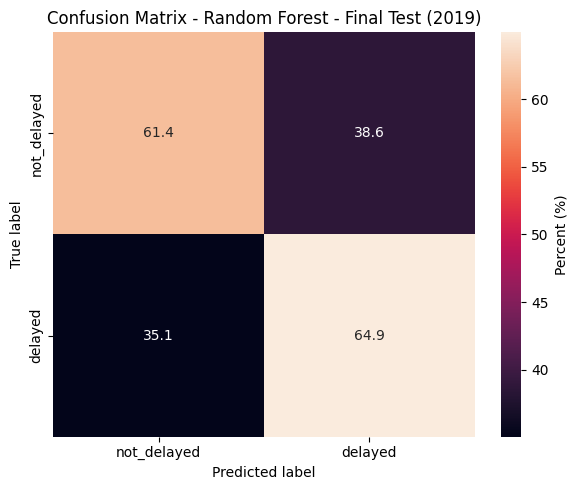

=== XGBoost - Final Test (2019) ===
Accuracy : 0.6606
F1-score: 0.6957
Precision: 0.7756
Recall   : 0.6606


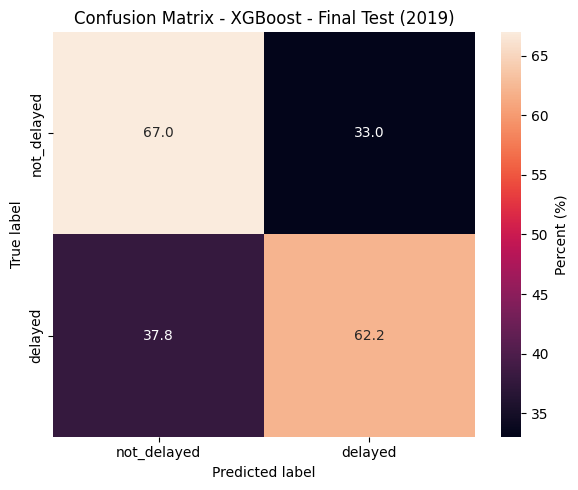

(0.660633890524799,
 0.6957240969524282,
 0.7756469655917955,
 0.660633890524799,
 array([[3817149, 1883372],
        [ 497323,  817279]]))

In [0]:
evaluate_model(rf_best_model, rf_best_pred_test, "Random Forest - Final Test (2019)")
evaluate_model(xgb_best_model, xgb_best_pred_test, "XGBoost - Final Test (2019)")

In [0]:
cv_rf_models = []
cv_xgb_models = []
for split in cv_dataset:
    train_df = split["train_df"]
    valid_df = split["test_df"]
    feats = split["feature_cols"]
    split_name_cv = split["name"]

    rf_save_path = f"{rf_best_models_dir}/{split_name_cv}"
    xgb_save_path = f"{xg_best_models_dir}/{split_name_cv}"

    rf_model, rf_pred, _, rf_train_time = load_or_train_rf_model(
        train_df, valid_df, feats, LABEL_COL, add_class_weights(), rf_best_params, rf_save_path
    )
    xgb_model, xgb_pred, _, xgb_train_time = load_or_train_xgb_model(
        train_df, valid_df, feats, LABEL_COL, add_class_weights(), xgb_best_params, xgb_save_path
    )

    cv_rf_models.append((rf_model, rf_pred, rf_train_time, split_name_cv))
    cv_xgb_models.append((xgb_model, xgb_pred, xgb_train_time, split_name_cv))

Loaded RF model from dbfs:/student-groups/Group_4_1/rf_cv_models_2/train_<= 2015_val_2016/best_model. Train time: 295.67 seconds
Loaded XGB model from dbfs:/student-groups/Group_4_1/xgb_cv_models_2/train_<= 2015_val_2016/best_model. Train time: 56.23 seconds
Loaded RF model from dbfs:/student-groups/Group_4_1/rf_cv_models_2/train_<= 2016_val_2017/best_model. Train time: 492.31 seconds
Loaded XGB model from dbfs:/student-groups/Group_4_1/xgb_cv_models_2/train_<= 2016_val_2017/best_model. Train time: 120.29 seconds
Loaded RF model from dbfs:/student-groups/Group_4_1/rf_cv_models_2/train_<= 2017_val_2018/best_model. Train time: 672.52 seconds
Loaded XGB model from dbfs:/student-groups/Group_4_1/xgb_cv_models_2/train_<= 2017_val_2018/best_model. Train time: 168.93 seconds


=== Random Forest CV - train_<= 2015_val_2016 ===
Accuracy : 0.6496
F1-score: 0.6910
Precision: 0.7859
Recall   : 0.6496


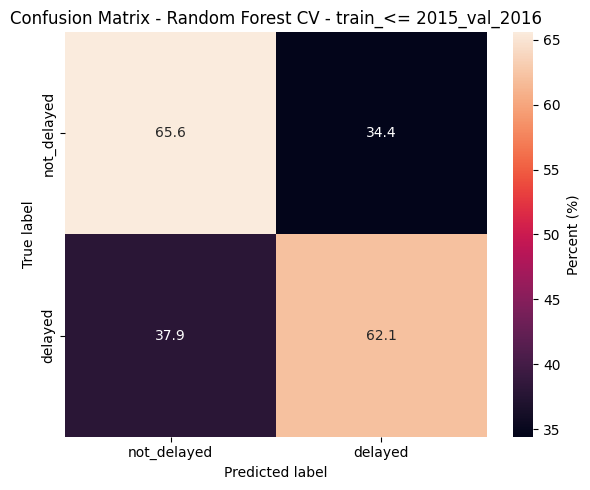

=== Random Forest CV - train_<= 2016_val_2017 ===
Accuracy : 0.6293
F1-score: 0.6714
Precision: 0.7802
Recall   : 0.6293


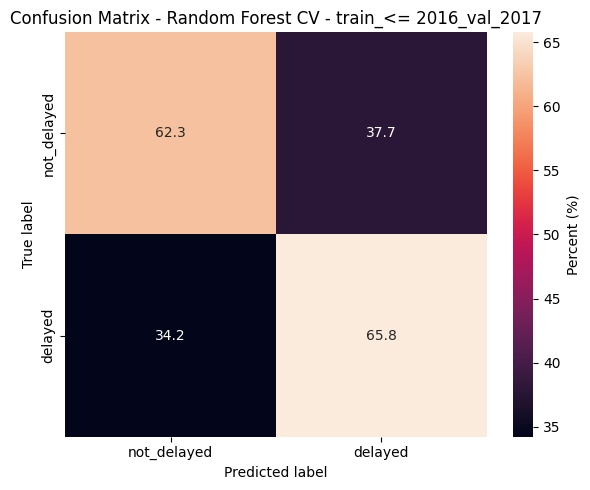

=== Random Forest CV - train_<= 2017_val_2018 ===
Accuracy : 0.6221
F1-score: 0.6642
Precision: 0.7772
Recall   : 0.6221


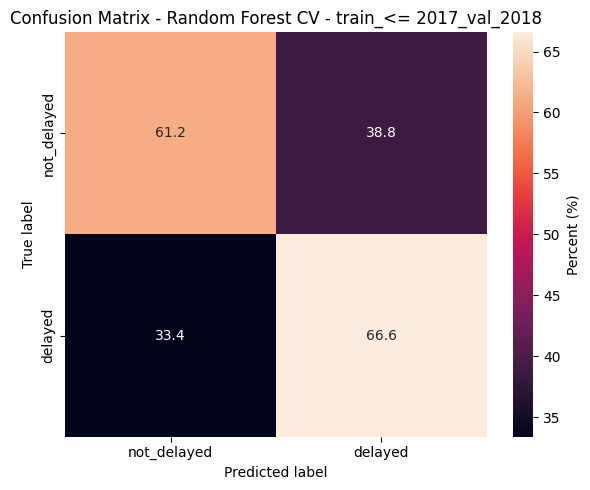

=== XGBoost CV - train_<= 2015_val_2016 ===
Accuracy : 0.7017
F1-score: 0.7319
Precision: 0.7883
Recall   : 0.7017


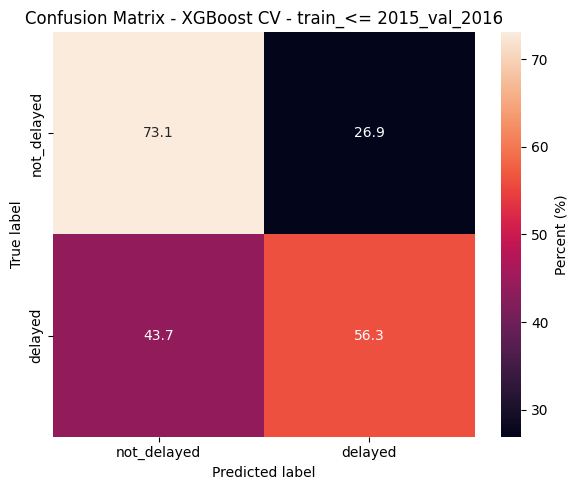

=== XGBoost CV - train_<= 2016_val_2017 ===
Accuracy : 0.6816
F1-score: 0.7144
Precision: 0.7840
Recall   : 0.6816


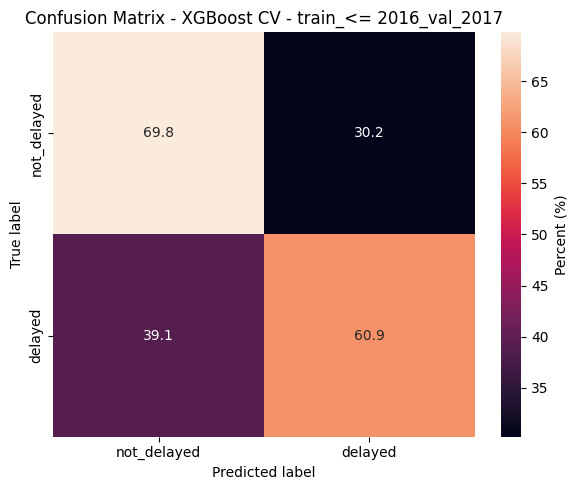

=== XGBoost CV - train_<= 2017_val_2018 ===
Accuracy : 0.6645
F1-score: 0.6999
Precision: 0.7808
Recall   : 0.6645


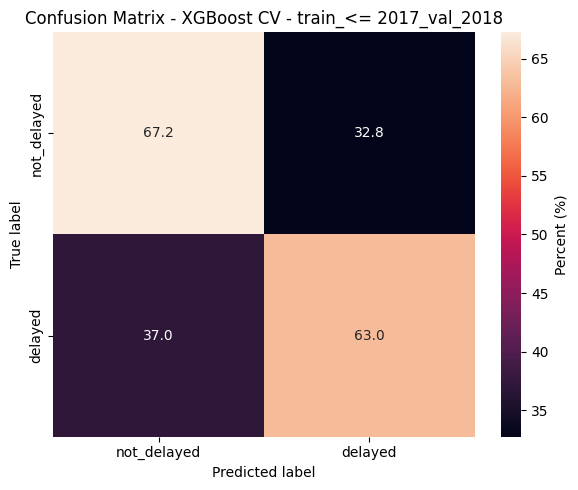

In [0]:
# Get all metrics for each CV split
rf_cv_metrics_df = collect_cv_metrics(cv_rf_models, "Random Forest")
xgb_cv_metrics_df = collect_cv_metrics(cv_xgb_models, "XGBoost")

=== Random Forest - Train (2015–2018) ===
Accuracy : 0.6230
F1-score: 0.6661
Precision: 0.7810
Recall   : 0.6230


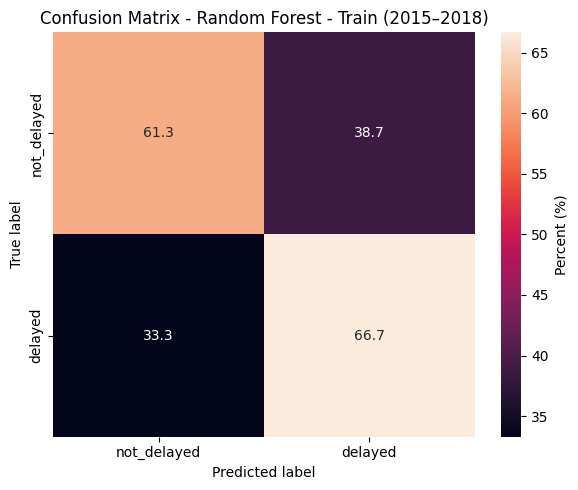

=== Random Forest - Test (2019) ===
Accuracy : 0.6205
F1-score: 0.6619
Precision: 0.7704
Recall   : 0.6205


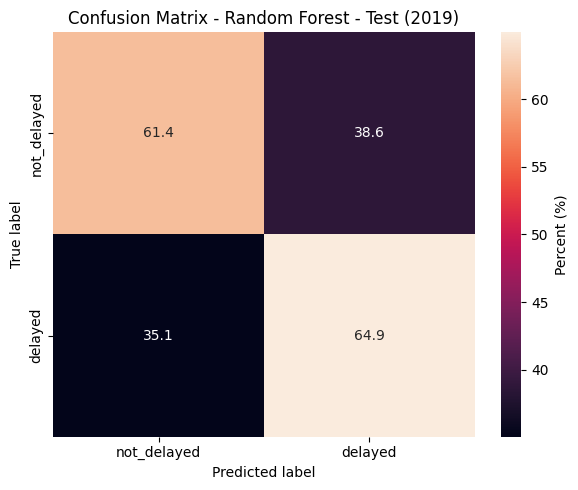

2025-12-12 16:27:49,296 WARNING XGBoost-PySpark: _gpu_transform Do the prediction on the CPUs since no gpu configurations are set


=== XGBoost - Train (2015–2018) ===
Accuracy : 0.6792
F1-score: 0.7140
Precision: 0.7974
Recall   : 0.6792


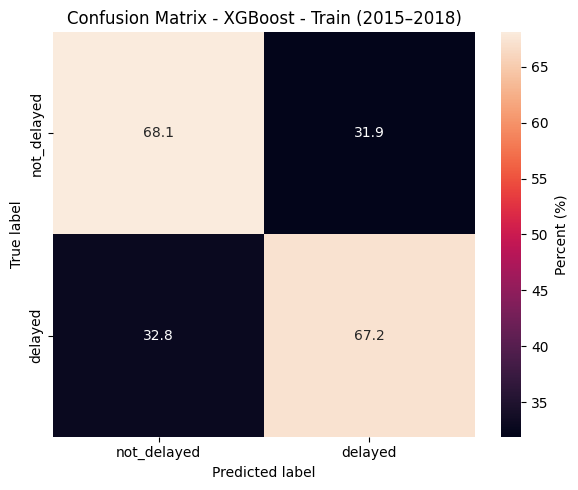

=== XGBoost - Test (2019) ===
Accuracy : 0.6606
F1-score: 0.6957
Precision: 0.7756
Recall   : 0.6606


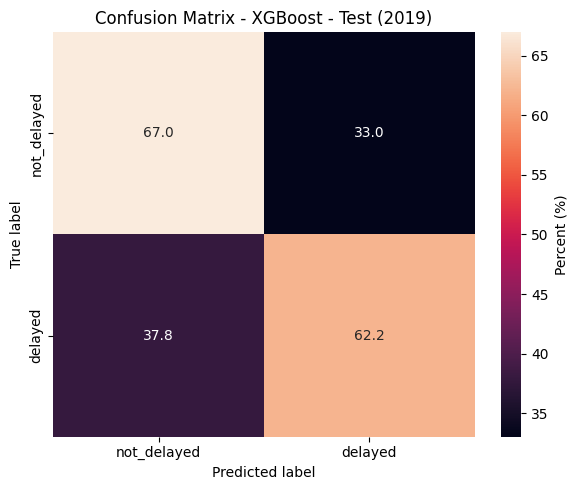

In [0]:
final_summary_df = collect_final_train_test_metrics(
    rf_best_model,
    rf_best_pred_test,
    xgb_best_model,
    xgb_best_pred_test,
    final_train_df
)

In [0]:
display(rf_cv_metrics_df)
display(xgb_cv_metrics_df)
display(final_summary_df)

model split accuracy precision recall f1 train_time_sec Random Forest train_<= 2015_val_2016 0.6496130123522191 0.785853394011865 0.6496130123522191 0.6910460425609617 295.6667037010193 Random Forest train_<= 2016_val_2017 0.6292636016059204 0.7801881662340099 0.6292636016059204 0.6713564227952776 492.31163239479065 Random Forest train_<= 2017_val_2018 0.6221440494340027 0.7771560293048855 0.6221440494340027 0.664224408384704 672.5204842090607 Random Forest CV (mean over folds) 0.6336735544640474 0.7810658631835867 0.6336735544640474 0.675542291246981 486.83294010162354

model split accuracy precision recall f1 train_time_sec XGBoost train_<= 2015_val_2016 0.7017360609864364 0.7883380032154298 0.7017360609864364 0.7318901603033859 56.23049879074097 XGBoost train_<= 2016_val_2017 0.6815627646363115 0.7840463346503389 0.6815627646363115 0.7144010471097887 120.28559947013855 XGBoost train_<= 2017_val_2018 0.6645375832072508 0.7807745523011842 0.6645375832072508 0.6998858331372186 168.9276421070099 XGBoost CV (mean over folds) 0.6826121362766662 0.7843862967223177 0.6826121362766662 0.715392346850131 115.14791345596313

model split accuracy precision recall f1 Random Forest Train (2015–2018) 0.6229604997770748 0.7809847368891201 0.6229604997770748 0.6660717862726123 Random Forest Test (2019) 0.6205017360351344 0.7704118965187209 0.6205017360351345 0.6618948663214783 XGBoost Train (2015–2018) 0.6792285675052444 0.7974397316564046 0.6792285675052444 0.7140489639354647 XGBoost Test (2019) 0.660633890524799 0.7756469655917955 0.660633890524799 0.6957240969524282

Early Stopping

In [0]:
def add_class_weights_simple(train_df, label_col="DEP_DELAY_GROUP_CLASSIFIED", weight_col="class_weight"):
    """
    Compute class weights for a *string* label column and attach a numeric
    weight column to train_df.
    w_c = N / (K * n_c)  (so average weight ~ 1)
    """
    counts = (
        train_df.groupBy(label_col)
        .count()
        .withColumnRenamed("count", "cnt")
    )

    total = counts.agg(F.sum("cnt")).first()[0]
    k = counts.count()

    weights_df = counts.withColumn(
        weight_col,
        (F.lit(float(total)) / (F.lit(float(k)) * F.col("cnt")))
    )

    train_with_w = train_df.join(
        weights_df.select(label_col, weight_col),
        on=label_col,
        how="left"
    )

    return train_with_w, weight_col

In [0]:
def train_xgb_with_early_stopping_from_full_df(
    full_df,
    feature_cols,
    best_params,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    raw_delay_col="DEP_DELAY_GROUP", 
    date_col="FL_DATE",
    val_year=2018,
    train_start_year=2015,
    train_end_year=2018,
    test_year=2019,
    apply_class_weights=True,
    early_stopping_rounds=10,
    weight_col="class_weight",
    val_flag_col="isVal",
):
    """
    Rebuild XGBoost final model with early stopping from the *full* dataset.

    Steps:
      1. Ensure label column exists (create from raw_delay_col if missing).
      2. Filter by year: 2015–2018 = train+val, 2019 = test.
      3. Inside 2015–2018, mark val_year (e.g., 2018) as validation for ES.
      4. Apply class weights on training window.
      5. Assemble features (numeric-only from feature_cols).
      6. Train SparkXGBClassifier with early_stopping_rounds.
    """

    df = full_df

    # 0) Make sure date column is usable
    if date_col not in df.columns:
        raise ValueError(f"date_col={date_col!r} not found in DataFrame.")

    df = df.withColumn("year", F.year(F.to_date(col(date_col))))

    # 1) Ensure label column exists
    if label_col not in df.columns:
        if raw_delay_col not in df.columns:
            raise ValueError(
                f"Neither label_col={label_col!r} nor raw_delay_col={raw_delay_col!r} "
                "found in DataFrame."
            )
        df = df.withColumn(
            label_col,
            F.when(F.col(raw_delay_col) >= 1, F.lit("delayed")).otherwise(F.lit("on_time"))
        )

    # 2) Split into train (2015–2018) and test (2019)
    train_window_df = df.filter(
        (col("year") >= F.lit(train_start_year)) &
        (col("year") <= F.lit(train_end_year))
    )

    test_df_es = df.filter(col("year") == F.lit(test_year))

    # 3) Mark internal validation rows (2018) for early stopping
    train_df_es = train_window_df.withColumn(
        val_flag_col,
        (col("year") == F.lit(val_year))
    )

    # 4) Apply class weights on training window
    if apply_class_weights:
        train_df_es, weight_col = add_class_weights_simple(
            train_df_es,
            label_col=label_col,
            weight_col=weight_col
        )

    # 5) Build numeric-only feature list that actually exists in this DF
    numeric_feature_cols = []
    schema = train_df_es.schema
    col_set = set(train_df_es.columns)

    for c in feature_cols:
        if c not in col_set:
            continue
        dt = schema[c].dataType
        if isinstance(dt, NumericType):
            numeric_feature_cols.append(c)

    if not numeric_feature_cols:
        raise ValueError(
            "After filtering to numeric + existing columns, "
            "no feature columns remain. Check feature_cols and DF schema."
        )

    # 6) XGBoost with early stopping
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )

    assembler = VectorAssembler(
        inputCols=numeric_feature_cols,
        outputCol="features",
        handleInvalid="keep",
    )

    xgb = SparkXGBClassifier(
        features_col="features",
        label_col="label",
        validation_indicator_col=val_flag_col,
        weight_col=weight_col if apply_class_weights else None,
        early_stopping_rounds=early_stopping_rounds,
        eval_metric="logloss",
        **best_params,
    )

    pipeline = Pipeline(stages=[label_indexer, assembler, xgb])

    # 7) Fit with ES on 2015–2018
    xgb_es_model = pipeline.fit(train_df_es)

    # 8) Predict on blind 2019 test
    xgb_es_pred_test = xgb_es_model.transform(test_df_es)

    return xgb_es_model, xgb_es_pred_test, train_df_es, test_df_es

In [0]:
xgb_es_model, xgb_es_pred_test, train_df_es, test_df_es = train_xgb_with_early_stopping_from_full_df(
    full_df=dfs[0]["df"],
    feature_cols=final_features,
    best_params=xgb_best_params,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    date_col="FL_DATE",
    val_year=2018,
    train_start_year=2015,
    train_end_year=2018,
    test_year=2019,
    apply_class_weights=True,
    early_stopping_rounds=10,
)

2025-12-12 16:30:42,416 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 1.0, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 10, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8, 'eval_metric': 'logloss', 'nthread': 1}
	train_call_kwargs_params: {'early_stopping_rounds': 10, 'verbose_eval': True, 'num_boost_round': 175}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-12-12 16:45:21,570 INFO XGBoost-PySpark: _fit Finished xgboost training!


=== XGBoost (Best Params + Early Stopping) - Test (2019) ===
Accuracy : 0.6635
F1-score: 0.6978
Precision: 0.7733
Recall   : 0.6635


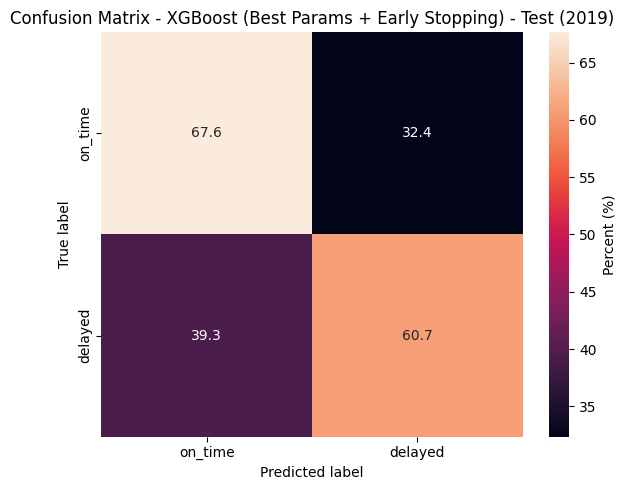

(0.6634624938151477,
 0.6977539212837306,
 0.7732868237216423,
 0.6634624938151477,
 array([[3855769, 1844752],
        [ 516100,  798502]]))

In [0]:
evaluate_model(
    xgb_es_model,
    xgb_es_pred_test,
    title="XGBoost (Best Params + Early Stopping) - Test (2019)",
)

In [0]:
train_pred_all = xgb_es_model.transform(train_df_es).cache()

train_pred_train = train_pred_all.filter(~F.col("isVal"))  # 2015–2017
train_pred_val   = train_pred_all.filter( F.col("isVal"))  # 2018

=== XGB ES – Train (2015–2017) ===
Accuracy : 0.6764
F1-score: 0.7120
Precision: 0.7966
Recall   : 0.6764


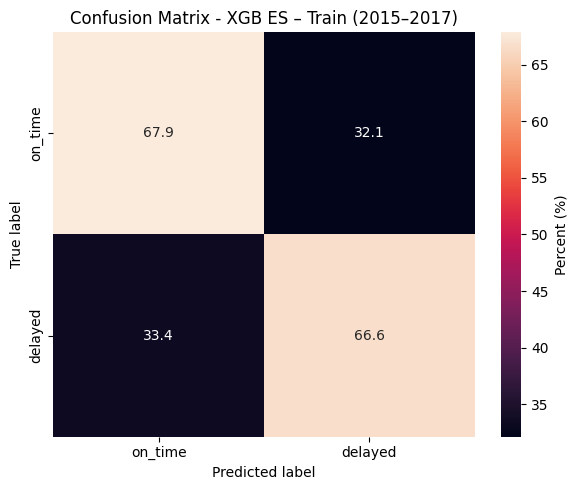

=== XGB ES – Internal Validation (2018) ===
Accuracy : 0.6619
F1-score: 0.6978
Precision: 0.7810
Recall   : 0.6619


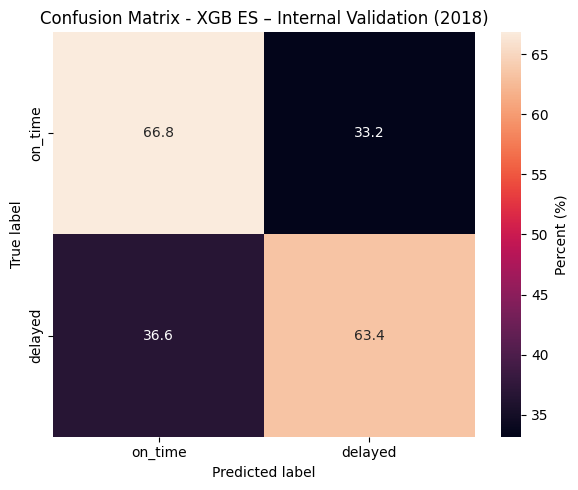

(0.6619141500782532,
 0.6977778820105384,
 0.7809540923266066,
 0.6619141500782532,
 array([[3766116, 1869448],
        [ 467895,  810001]]))

In [0]:
# Train metrics (2015–2017)
train_metrics = evaluate_model(
    xgb_es_model,
    train_pred_train,
    title="XGB ES – Train (2015–2017)",
)

# Internal validation metrics (2018)
evaluate_model(
    xgb_es_model,
    train_pred_val,
    title="XGB ES – Internal Validation (2018)",
)
